In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def preprocess_images(data_path, flag):
        l = []
        for file in os.listdir(data_path):
            img_path = os.path.join(data_path, file)
            img_arr = cv2.imread(img_path)
            img_arr = cv2.resize(img_arr, (224, 224))
            img_arr = img_arr / 255.0
            l.append((img_arr, flag))
        return list(l)

In [4]:
train_path = "/content/drive/MyDrive/data/chicken-images/data/train"
test_path = "/content/drive/MyDrive/data/chicken-images/data/test"
val_path = "/content/drive/MyDrive/data/chicken-images/data/val"

train_data = preprocess_images(train_path, 0)
test_data = preprocess_images(test_path, 0)
val_data = preprocess_images(val_path, 0)

train_path = "/content/drive/MyDrive/data/duck-images/data/train"
test_path = "/content/drive/MyDrive/data/duck-images/data/test"
val_path = "/content/drive/MyDrive/data/duck-images/data/val"

train_data = train_data + preprocess_images(train_path, 1)
test_data = test_data + preprocess_images(test_path, 1)
val_data = val_data + preprocess_images(val_path, 1)

np.random.shuffle(train_data)
np.random.shuffle(test_data)
np.random.shuffle(val_data)

train_classes = np.array([y for (x, y) in train_data])
test_classes = np.array([y for (x, y) in test_data])
val_classes = np.array([y for (x, y) in val_data])

train_data =  np.array([x for (x, y) in train_data])
test_data = np.array([x for (x, y) in test_data])
val_data = np.array([x for (x, y) in val_data])

In [5]:
pretrained_model = VGG19(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
for layer in pretrained_model.layers:
    layer.trainable = False

x = Flatten()(pretrained_model.output)

prediction = Dense(2, activation="softmax")(x)

model = Model(inputs=pretrained_model.input, outputs=prediction)

80134624/80134624 [==============================] - 1s 0us/step


In [6]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Compiling and Fitting the model

In [7]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to avoid overfitting of model
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)


# fit the model
history = model.fit(
    train_data,
    train_classes,
    validation_data=(val_data, val_classes),
    epochs=10,
    callbacks=[early_stop],
    batch_size=32,
    shuffle=True,
)

Epoch 1/10
29/29 [==============================] - 898s 31s/step - loss: 0.7847 - accuracy: 0.7200 - val_loss: 0.4123 - val_accuracy: 0.8385
Epoch 2/10
29/29 [==============================] - 882s 30s/step - loss: 0.2176 - accuracy: 0.9074 - val_loss: 0.4245 - val_accuracy: 0.8447
Epoch 3/10
29/29 [==============================] - 878s 30s/step - loss: 0.0895 - accuracy: 0.9768 - val_loss: 0.4330 - val_accuracy: 0.8571
Epoch 4/10
29/29 [==============================] - 870s 30s/step - loss: 0.0665 - accuracy: 0.9890 - val_loss: 0.4140 - val_accuracy: 0.8571
Epoch 5/10
29/29 [==============================] - 871s 30s/step - loss: 0.0407 - accuracy: 0.9967 - val_loss: 0.3143 - val_accuracy: 0.8634
Epoch 6/10
29/29 [==============================] - 863s 30s/step - loss: 0.0353 - accuracy: 0.9978 - val_loss: 0.3825 - val_accuracy: 0.8696
Epoch 7/10
29/29 [==============================] - 864s 30s/step - loss: 0.0260 - accuracy: 1.0000 - val_loss: 0.3350 - val_accuracy: 0.8696
Epoch 

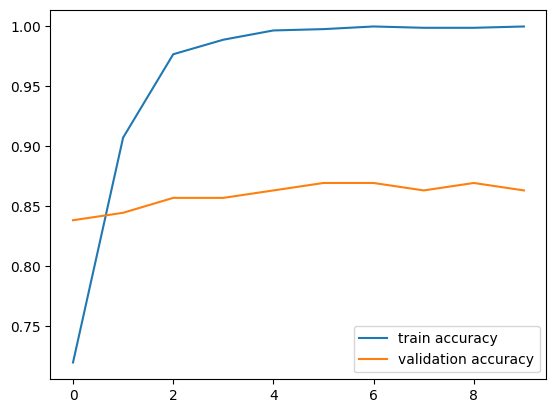

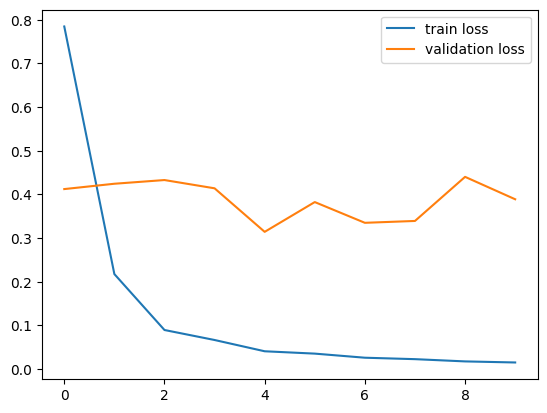

In [9]:
plt.plot(history.history["accuracy"], label="train accuracy")

plt.plot(history.history["val_accuracy"], label="validation accuracy")

plt.legend()

plt.savefig("train-val-accuracy-graph.png")

plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.savefig("train-val-loss-graph.png")
plt.show()

# Evaluating the model

In [10]:
model.evaluate(test_data, test_classes, batch_size=32)

16/16 [==============================] - 396s 24s/step - loss: 0.2806 - accuracy: 0.8984


[0.28057610988616943, 0.8983739614486694]

In [11]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
print(classification_report(predictions, test_classes))
print(confusion_matrix(predictions, test_classes))

16/16 [==============================] - 400s 25s/step
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       150
           1       0.96      0.89      0.92       342

    accuracy                           0.90       492
   macro avg       0.87      0.90      0.88       492
weighted avg       0.91      0.90      0.90       492

[[136  14]
 [ 36 306]]
